# Homework #7 (Due 10/30/2019, 11:59pm)
## Bayesian Neural Networks

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2019**

**Name: Ian Weaver**

**Students collaborators:**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [3]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import sys
%matplotlib inline

In [4]:
# Plot configs
fig_wide = (11, 4)
%config InlineBackend.figure_format = "retina"
%matplotlib inline
sns.set(style="darkgrid", palette="colorblind", color_codes=True)

In [ ]:
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param=None):
        ''' Make objective functions: depending on whether or not you want to apply l2 regularization '''
        
        if reg_param is None:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                sum_error = np.sum(squared_error)
                return sum_error
            
            return objective, grad(objective)
            
        else:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error
            
            return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):
        ''' Wrapper for MLE through gradient descent '''
        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

## Problem Description: Bayesian Neural Network Regression
In Lab #7, you will explore MLE models for regression with neural networks. For contrast, in this homework you will explore Bayeisan models for regression with neural networks -- essentially, you will place priors on the network parameters $\mathbf{W}$ and infer the posterior $p(\mathbf{W}|\text{Data})$. These Bayesian models are called ***Bayesian neural networks***. The data for this regression problem is in `HW7_data.csv`. You are provided an implementation of a neural network as well as an example of how to use it -- but feel free to implement your own version!

### Part I: Implement Hamiltonian Monte Carlo

1. (**The Sampler**) Implement Hamiltonian Monte Carlo with:
  - Euclidean-Gaussian Kinetic Energy, with mass $m=1$ (see Lecture #12 Notes)
  - Leap-frog integrator<br><br>

2. (**Unit Test**) Check that your implementation is correct by running it on a standard normal distribution $\mathcal{N}(0, 1)$ as your target distribution and initializing at $q = -10$. Check that the histogram of HMC samples (after appropriate burn-in and thinning) look like a standard normal and that the traceplot of $q$ indicates convergence.<br><br>

#### 1.1 HMC Sampler

The general outline for our HMC sampler is the following for approximating a target distribution $\pi(q)$, where $p$ and $q$ are the position and momentum of a walker in our parameters space with dimensionality $\mathbb R^D$:

- Re-rewrite $\pi$ as a potential energy function $U(q) = -\log\pi(q)$
- Pick a kinetic energy function $K$ that can be easily sampled from its Gibbs distribution
- Pick a random $q_0 \in \mathbb R^D$ for a walker
- Repeat N times:
    - Start the walker with a random momentum vector $p$ sampled from $K$
    - Let the walker travel around the parameter space following the Hamiltonian, 
      H = U(q) + K(p)
        - Use your favorite volume-preserving and reversible numerical integration scheme
          here to accomplish this
    - After a set amount of time (T), stop the walker and decided whether to accept 
      its final location or not via a Metropolis-Hastings mechanism 
        - e.g. $\alpha = \text{min}\left[1, 
        \text{exp}\left(\left|H_f - H_0\right|\right)\right]$, 
        accept if $U(0, 1) \le \alpha$
    
This can be done with many walkers to help check for convergence. A synchronized leap-frog algorithm to perform the Hamiltonian integration would look like the following:

\begin{align}
p_{t+1/2} &= p_t - \frac{\epsilon}{2}\frac{\partial U}{\partial q}(q_t) \\
q_{t+1} &= q_t + \epsilon\frac{\partial K}{\partial p}(p_{t + 1/2}) \\
p_{t+1} &= p_{t + 1/2} - \frac{\epsilon}{2}\frac{\partial U}{\partial q}(q_{t+1}) \quad,
\end{align}

where $t$ is the current step and $\epsilon$ is its duration. All we need now is a kinetic energy distribution that we can sample from. Using a Euclidean-Gaussian kinetic energy, we have the following:

\begin{align}
K(p) = \frac{1}{2} p^\top M^{-1} p + \frac{1}{2}\log|M| + \frac{D}{2} \log(2\pi) \quad,
\end{align}

where $M = m \mathbf{I}_{D\times D}$. This is awesome because if we write it's corresponding Gibbs distribution, we have:

\begin{align}
\pi_K(p) = \frac{1}{Z}\exp\left[-K(p)\right] 
= \frac{1}{Z} \frac{1}{(2\pi)^{D/2}|M|^{1/2}} 
\exp\left(-\frac{1}{2}p^\top M^{-1} p\right) \quad,
\end{align}

which is the pdf for the multivariate normal $\mathcal N(0, M)$! Assuming $M$ is positive definite, we know this kind of pdf already integrates to one, so $Z = 1$. The implementation for this HMC scheme is shown below.

In [5]:
# HMC implementation
def HMC(*, target, q0, N, K, p_samp, integrator, T, dt):
    q_current = q0
    U = lambda q: -np.log(target(q))
    dUdq = grad(U)
    dKdp = grad(K)
    samples = [q_current]
    accept = 0
    for n in range(N):
        p_current = p_samp() # kick-off momentum of walker
        # travel according to Hamiltonian
        q_prop, p_prop = integrator(
            q0=q_current,
            p0=p_current,
            dqdt=dKdp,
            dpdt=dUdq,
            T=T,
            dt=dt,
        )
        
        # M-H accept/reject step
        H_f = U(q_prop) + K(p_prop)
        H_0 = U(q_current) + K(p_current)
        log_alpha = np.min([0, H_0 - H_f])
        log_U = np.log(np.random.uniform())
        if log_U <= log_alpha:
            accept += 1
            q_current = q_prop
        else:
            pass
        
        samples.append(q_current)
        
    samples = np.array(samples).reshape(len(samples), 1)
    return(samples), accept / N
    
def leap_frog(*, q0, p0, dqdt, dpdt, T, dt):
    # integrates q and p given dq/dt, dp/dt
    q_t, p_t = q0, p0
    for t in range(T):
        p_t_half = p_t - 0.5*dt*dpdt(q_t) # half step
        q_t_full = q_t + dt*dqdt(p_t_half) # full step
        p_t_full = p_t_half - 0.5*dt*dpdt(q_t_full) # half step
        
        # update
        p_t = p_t_full
        q_t = q_t_full
    
    return np.array([q_t, -p_t]) # momentum flip

#### 1.2 Unit test

In [6]:
# set inputs
HMC_unittest_params = {
########################
# target distribution
########################
"target": sp.stats.norm.pdf, # target distribution
}
################################
# kinetic energy distribution
################################
mean = np.array([0]) 
D = len(mean) # dimensionality
m = 1. # mass
M = m*np.identity(D) # mass matrix
p_samp = lambda: np.random.multivariate_normal(mean=mean, cov=M)
M_inv = np.linalg.inv(M)
c1 = 0.5*np.log(np.linalg.det(M))
c2 = 0.5*D*np.log(2*np.pi)
K = lambda p: 0.5*p.T@M_inv@p + c1 + c2 # calculates kinetic energy
HMC_unittest_params.update({
    "p_samp":p_samp,
    'K': K
})
##########################
# simulation parameters
##########################
HMC_unittest_params.update({
'N': 200, # number of steps
"integrator": leap_frog, # numerical integrator
"q0":  np.array([-10.]).reshape(1, 1), # starting point
'T': 10, # number of integration steps
"dt": 1.5, # integration step interval
})

# run HMC
samples, accept_rate = HMC(**HMC_unittest_params)

accept rate: 0.78
burned first 20 samples and thinned every 2
initial sample size: 200
final sample size: 91


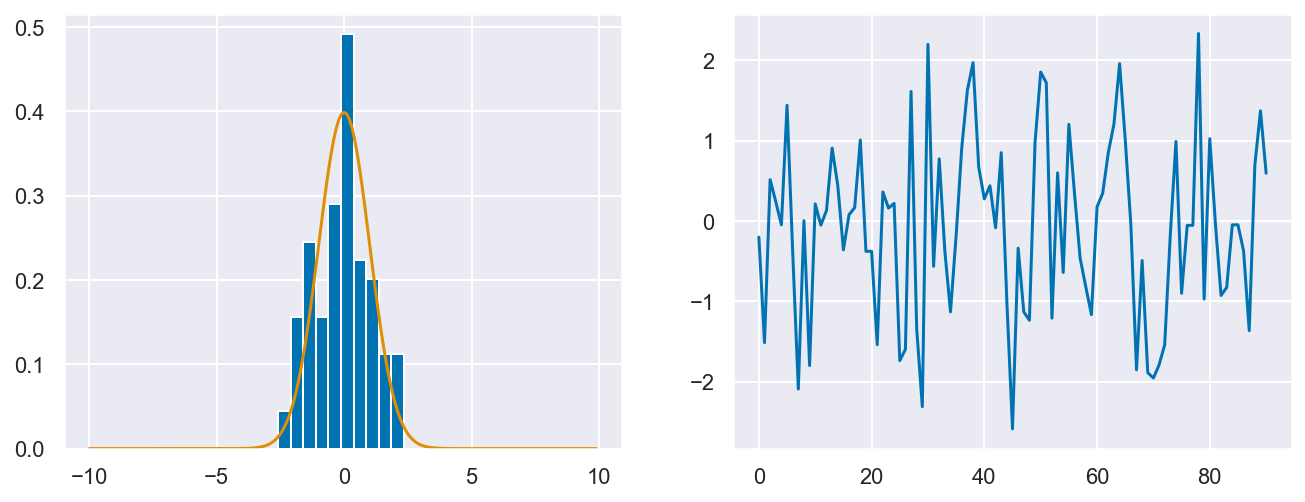

In [10]:
# display results
fig, axes = plt.subplots(1, 2, figsize=fig_wide)
print(f"accept rate: {accept_rate}")
N = len(samples)
burn = int(0.1*N)
thin = 2
print(f"burned first {burn} samples and thinned every {thin}")
samples_reduced = samples[burn::thin]
print(f"initial sample size: {HMC_unittest_params['N']}")
print(f"final sample size: {len(samples_reduced)}")
axes[0].hist(samples_reduced, density=True)
x = np.arange(-10, 10, 0.1)
axes[0].plot(x, HMC_unittest_params["target"](x))

axes[1].plot(samples_reduced)

### Part II: Sample from the Posterior of a Bayesian Neural Network

1. (**The Bayesian Neural Network Model**) We will implement the following Bayesian model for the data:

\begin{align}
\mathbf{W} &\sim \mathcal{N}(0, 5^2 \mathbf{I}_{D\times D})\\
\mu^{(n)} &= g_{\mathbf{W}}(\mathbf{X}^{(n)})\\
Y^{(n)} &\sim \mathcal{N}(\mu^{(n)}, 0.5^2)
\end{align}

$\quad\quad$where $g_{\mathbf{W}}$ is a neural network with parameters $\mathbf{W}$ represented as a vector in $\mathbb{R}^{D}$ with $D$ being the total number of parameters (including biases).

$\quad\quad$Implement the log of the joint distribution in `autograd`'s version of `numpy`, i.e. implement $\log \left[p(\mathbf{W})\prod_{n=1}^N p(Y^{(n)} |\mathbf{X}^{(n)} , \mathbf{W}) \right]$.
  
$\quad\quad$***Hint:*** you'll need to write out the log of the various Gaussian pdf's and implement their formulae using `autograd`'s numpy functions.<br><br>
  
2. (**The Unnormalized Posterior is Enough**) By Bayes rule, the posterior $p(\mathbf{W}|\text{Data})= \frac{\log \left[p(\mathbf{W})\prod_{n=1}^N p(Y^{(n)} |\mathbf{X}^{(n)} , \mathbf{W}) \right]}{\mathcal{Z}}$, where $\mathcal{Z}$ is a normalizing constant defined by a complicated integral. Argue that we do not need to evaluate $\mathcal{Z}$ for HMC sampling from the posterior. In particular, examine the Metropolis-Hasting acceptance mechanism in HMC and argue that the normalizing constant is not needed; furthermore, examine the gradient update steps in the leap-frog integrator and argue that we do not need the normalizing constant in the gradient update.<br><br>

3. (**Sample from the Posterior**) Use HMC to sample from the posterior of the Bayesian neural network. Start with the following settings for your sampler:
``` python
params = {'step_size':1e-3, 
          'leapfrog_steps':50, 
          'total_samples':10000, 
          'burn_in':.1, 
          'thinning_factor':2,
          'position_init': nn.weights}
```
  Note that you should initialize with the MLE model, otherwise convergence may be slow. Please feel free to tweak these design choices as you see fit!<br><br>
  
4. (**Visualize the Posterior Predictive**) Visualize 100 samples, randomly selected, from your posterior samples of $\mathbf{W}$, by ploting their predicted values plus a random noise $\epsilon \sim \mathcal{N}(0, 0.5^2)$ at 100 equally spaced x-values between -8 and 8:
``` python 
x_test = np.linspace(-8, 8, 100)
y_test = nn.forward(sample, x_test.reshape((1, -1)))
```
  where `sample` is a posterior sample of $\mathbf{W}$.<br><br>

5. (**Computing the Fit**) Compute the posterior predictive log likelihood of the observed data under your model. 

  Not required for you to worry about for this problem, but note that this is a Monte Carlo estimation of an integral, so you'll need to worry about variance and all that.<br><br>
  
6. (**Model Evaluation**) Discuss the fit of your model to the data. Discuss also what the posterior predictive tell you about the aleatoric and epistemic uncertainty of the model. Are these uncertainties what you'd want (think about want kind of uncertainties you want and where)?

In [ ]:
data = pd.read_csv('HW7_data.csv')
x = data['x'].values
y = data['y'].values
data.head()

In [ ]:
###define rbf activation function
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

In [ ]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':2000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)

In [ ]:
x_test = np.linspace(-8, 8, 100)
y_test = nn.forward(nn.weights, x_test.reshape((1, -1)))
plt.scatter(x, y, color='k', label='data')
plt.plot(x_test, y_test.flatten(), color='r', label='learned neural network function')
plt.legend(loc='best')
plt.show()